**Optional**: create a local virtual environment and register a Jupyter kernel

If you don't have a virtual environment for this project, run the cell below to create `.venv`, install common ML packages, and register a kernel named `ml-self-study`. The cell prefers Python 3.10 if available; otherwise it will use the system Python. Skip this cell if you already have an environment.

In [8]:
%%bash
python -m pip install jupyterlab notebook ipykernel scikit-learn matplotlib numpy pandas seaborn joblib


# Learning Curves — practice with scikit-learn

This notebook reproduces the scikit-learn 'plot_learning_curve' example from  https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html and provides hands-on exercises. Objectives:
- Reproduce the learning-curve plot for a classifier.
- Interpret the learning curve (bias vs variance).
- Try different models, preprocessing, and datasets.

In [1]:
# Imports
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')
from sklearn.model_selection import learning_curve, ShuffleSplit
from sklearn.datasets import load_digits, fetch_california_housing
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

## What `learning_curve` computes (high-level)

The `learning_curve` helper measures model performance as the training set size grows. For each value in `train_sizes` it:

1. Repeats a cross-validation loop (using the `cv` splitter you provide).
2. For every CV split:
   - Selects a subset of the training fold with the requested number of training examples,
   - Fits the estimator on that subset,
   - Computes the score on the training subset (training score) and on the validation fold (validation score).
3. Aggregates the scores across CV splits and returns arrays: `train_sizes`, `train_scores`, `test_scores`.

Plotting the mean ± std of the training and cross-validation scores vs. training size helps diagnose:
- High bias — both training and validation scores are low and close together.
- High variance — training score is high but validation score is much lower.

Simple illustrative pseudo-code (high-level):

```python
import numpy as np
from sklearn.model_selection import ShuffleSplit

def manual_learning_curve(estimator, X, y, train_sizes, cv):
    train_scores = []
    test_scores = []
    for n in train_sizes:
        # n may be a fraction (0.1..1.0) or an absolute count
        n_train = int(n * len(X)) if 0 < n <= 1 else int(n)
        scores_train_n = []
        scores_test_n = []
        for train_idx, test_idx in cv.split(X, y):
            subset_idx = np.random.choice(train_idx, n_train, replace=False)
            estimator.fit(X[subset_idx], y[subset_idx])
            scores_train_n.append(estimator.score(X[subset_idx], y[subset_idx]))
            scores_test_n.append(estimator.score(X[test_idx], y[test_idx]))
        train_scores.append(scores_train_n)
        test_scores.append(scores_test_n)
    return np.array(train_scores), np.array(test_scores)
```

Tips:
- `train_sizes` accepts fractions (portion of full training data) or absolute counts.
- Wrap preprocessing in a `Pipeline` so transforms occur inside each CV loop.
- Set `n_jobs` to parallelize calls where supported, and pick an appropriate `scoring` for your task.

In [2]:
# Utility: plot_learning_curve function (compatible with scikit-learn's example)
import warnings
warnings.filterwarnings('ignore')

def plot_learning_curve(estimator, title, X, y, cv=None, n_jobs=None,
                        train_sizes=np.linspace(0.1, 1.0, 5), ylim=None):
    """
    Generate a simple plot of the test and training learning curve.
    Returns the matplotlib figure object.
    """
    plt.figure(figsize=(8, 6))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel('Training examples')
    plt.ylabel('Score')

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color='r')
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color='g')
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')
    plt.legend(loc='best')
    plt.tight_layout()
    return plt

## Learning curve evaluation on the Digits dataset

Dataset — `digits`

- The `digits` dataset contains 1,797 images of handwritten digits. Each image is 8×8 pixels and is represented as a 64-dimensional feature vector (pixel intensities). The target is an integer label 0–9 (10 classes). For more information see https://archive.ics.uci.edu/dataset/80/optical+recognition+of+handwritten+digits

Key components used in this example:

- `ShuffleSplit` — a cross-validator that generates repeated randomized train/test splits. For each split it shuffles indices and returns train/test indices; useful for estimating performance variability (used here for the repeated splits in the learning curve).

- `SVC` — Support Vector Classifier (SVM). A margin-based classifier that can use different kernels (RBF, linear, polynomial). Important hyperparameters include `C` (regularization strength) and `gamma` (kernel width for RBF). When applied to raw pixel features SVMs often benefit from scaling.  For more information see https://www.geeksforgeeks.org/machine-learning/introduction-to-support-vector-machines-svm/

- `make_pipeline` — a small utility that chains preprocessing steps and an estimator (e.g., `StandardScaler` then `SVC`) into a single estimator. Using a pipeline ensures preprocessing happens inside each cross-validation fold, avoiding data leakage and simplifying use with `learning_curve` and other scikit-learn helpers.

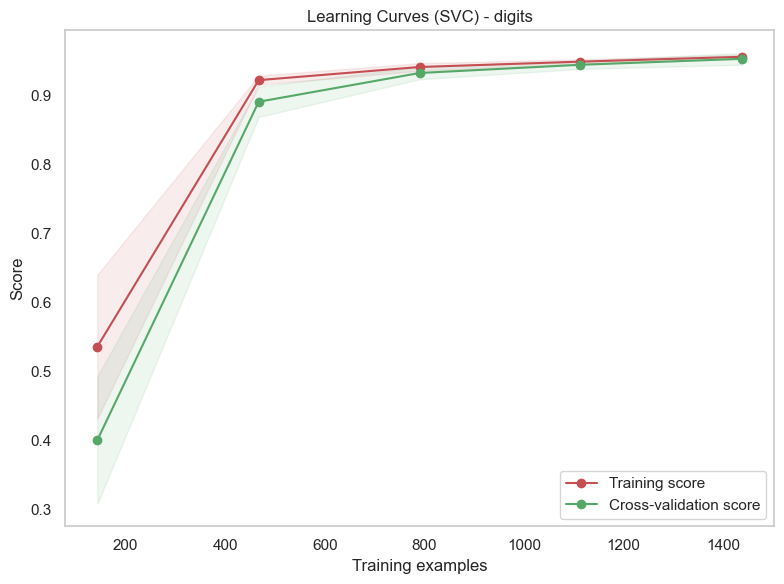

In [5]:
# Example 1: digits dataset + SVC (with a scaler in a pipeline)
from sklearn.datasets import load_digits
from sklearn.model_selection import ShuffleSplit

data = load_digits()
X, y = data.data, data.target
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

estimator = make_pipeline(StandardScaler(), SVC(gamma=0.001))
plot_learning_curve(estimator, 'Learning Curves (SVC) - digits', X, y, cv=cv, n_jobs=1)
plt.show()

## Learning curves using a different estimator.

Random forests consist of an ensemble of decision trees trained on random subsets of the training data. Before the deep learning revolution they were considered the SOTA for training on large datasets. https://www.statology.org/random-forests/

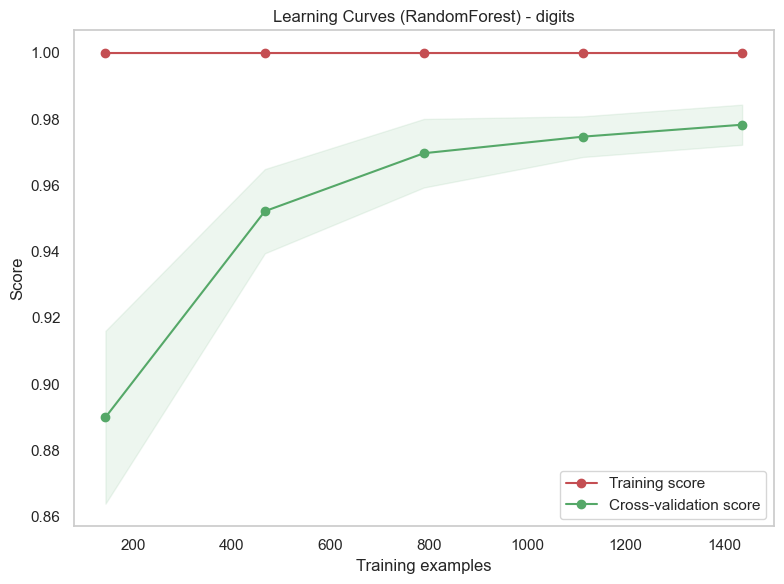

In [6]:
# Example 2: RandomForest on the same dataset (no scaler required)
estimator_rf = RandomForestClassifier(n_estimators=100, random_state=0)
plot_learning_curve(estimator_rf, 'Learning Curves (RandomForest) - digits', X, y, cv=cv, n_jobs=1)
plt.show()

## Exercises

- Try different estimators (LogisticRegression, SVC with different kernels, RandomForest, GradientBoosting, MLP).
- Add a preprocessing step (StandardScaler) when using SVM or MLP.
- Change the `train_sizes` grid and see how the curve behaves for small/large training sets.
- Compare models on different datasets: `iris`, `wine`, `breast_cancer`, `fetch_california_housing` (regression).
- Interpret the curves: identify signs of high bias and high variance and suggest fixes.

**Warning**: the example below may take several minutes to complete

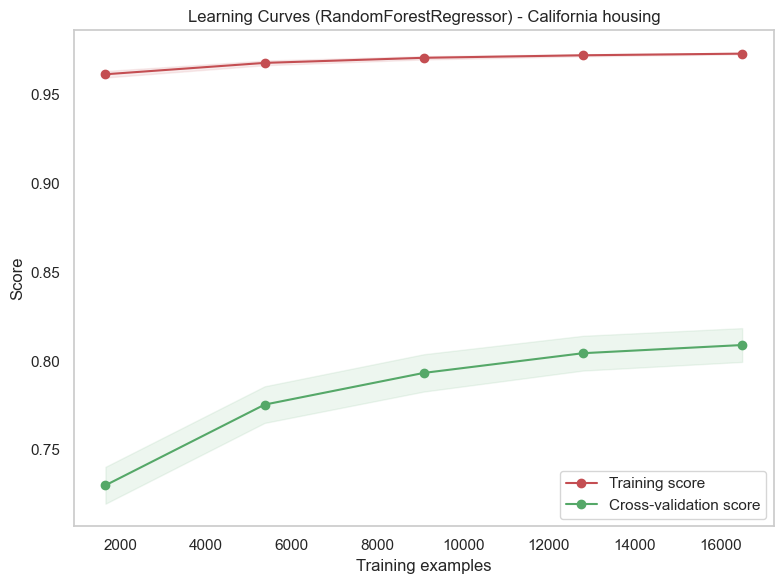

In [7]:
# Regression example: learning curve for a regressor using California housing
from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing(as_frame=True)
Xh = housing.data
yh = housing.target

est_reg = make_pipeline(StandardScaler(), RandomForestRegressor(n_estimators=100, random_state=0))
plot_learning_curve(est_reg, 'Learning Curves (RandomForestRegressor) - California housing', Xh, yh, cv=cv, n_jobs=1)
plt.show()

## Suggestions

- Models to try: LogisticRegression, SVC, RandomForest, HistGradientBoosting (scikit-learn), optionally XGBoost / LightGBM, MLP, KNN.
- Datasets to explore: `iris`, `wine`, `breast_cancer`, `digits`, `diabetes`, `fetch_california_housing`, and larger UCI/Kaggle datasets for scaling experiments.
- Useful extensions: use validation curves to probe hyperparameters; wrap preprocessing + estimator in a `Pipeline` and run `GridSearchCV` or `RandomizedSearchCV`; use stratified CV and task-appropriate metrics (e.g., `f1`, `roc_auc`) for imbalanced problems.

These suggestions complement the hands-on exercises above — try combinations of models, datasets, and evaluation protocols rather than repeating the same checklist.

## Next steps

- Create validation curves to explore hyperparameters (use `validation_curve`).
- Use `GridSearchCV` or `RandomizedSearchCV` inside a pipeline and inspect CV results.
- Apply learning-curve diagnostics to new problems (classification vs regression) and document findings.